# **Malicious URL Detection**
**Sardar Patel Institute of Technology, Mumbai**

**ETEL72A Cryptography and Network Security Lab**

**BE EXTC 2021-2022**

**Mini Project**

**Harsh Dungrani 2018120020**

**Yagnesh Gotad 2018120023**

In [ ]:
!pip install tld

     |████████████████████████████████| 412 kB 5.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from tld import get_tld
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
urldata = pd.read_csv("urldata.csv")
urldata.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [ ]:
urldata.isnull().sum()

Unnamed: 0    0
url           0
label         0
result        0
dtype: int64

In [ ]:
urldata = urldata.drop('Unnamed: 0',axis=1)
urldata.head()

,url,label,result
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


In [ ]:
urldata.shape

(450176, 3)

In [ ]:
urldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     450176 non-null  object
 1   label   450176 non-null  object
 2   result  450176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


In [ ]:
#Length of URL
urldata['url_length'] = urldata['url'].apply(lambda i: len(str(i)))

#Hostname Length
urldata['hostname_length'] = urldata['url'].apply(lambda i: len(urlparse(i).netloc))

#Path Length
urldata['path_length'] = urldata['url'].apply(lambda i: len(urlparse(i).path))

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

urldata['fd_length'] = urldata['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
urldata['tld'] = urldata['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

urldata['tld_length'] = urldata['tld'].apply(lambda i: tld_length(i))


In [ ]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld,tld_length
0,https://www.google.com,benign,0,22,14,0,0,com,3
1,https://www.youtube.com,benign,0,23,15,0,0,com,3
2,https://www.facebook.com,benign,0,24,16,0,0,com,3
3,https://www.baidu.com,benign,0,21,13,0,0,com,3
4,https://www.wikipedia.org,benign,0,25,17,0,0,org,3


In [ ]:
urldata = urldata.drop("tld",1)

In [ ]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length
0,https://www.google.com,benign,0,22,14,0,0,3
1,https://www.youtube.com,benign,0,23,15,0,0,3
2,https://www.facebook.com,benign,0,24,16,0,0,3
3,https://www.baidu.com,benign,0,21,13,0,0,3
4,https://www.wikipedia.org,benign,0,25,17,0,0,3


In [ ]:
#Count Features
urldata['count-'] = urldata['url'].apply(lambda i: i.count('-'))
urldata['count@'] = urldata['url'].apply(lambda i: i.count('@'))
urldata['count?'] = urldata['url'].apply(lambda i: i.count('?'))
urldata['count%'] = urldata['url'].apply(lambda i: i.count('%'))
urldata['count.'] = urldata['url'].apply(lambda i: i.count('.'))
urldata['count='] = urldata['url'].apply(lambda i: i.count('='))
urldata['count-http'] = urldata['url'].apply(lambda i : i.count('http'))
urldata['count-https'] = urldata['url'].apply(lambda i : i.count('https'))
urldata['count-www'] = urldata['url'].apply(lambda i: i.count('www'))

In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
urldata['count-digits']= urldata['url'].apply(lambda i: digit_count(i))

In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
urldata['count-letters']= urldata['url'].apply(lambda i: letter_count(i))

In [ ]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
urldata['count_dir'] = urldata['url'].apply(lambda i: no_of_dir(i))

In [ ]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir
0,https://www.google.com,benign,0,22,14,0,0,3,0,0,0,0,2,0,1,1,1,0,17,0
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,0,0,0,2,0,1,1,1,0,18,0
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,0,0,0,2,0,1,1,1,0,19,0
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,0,0,0,2,0,1,1,1,0,16,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,0,0,0,2,0,1,1,1,0,20,0


In [ ]:
import re

#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return -1
    else:
        # print 'No matching pattern found'
        return 1
urldata['use_of_ip'] = urldata['url'].apply(lambda i: having_ip_address(i))

#If url is shortened
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return -1
    else:
        return 1
urldata['short_url'] = urldata['url'].apply(lambda i: shortening_service(i))

In [ ]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,https://www.google.com,benign,0,22,14,0,0,3,0,0,0,0,2,0,1,1,1,0,17,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,0,0,0,2,0,1,1,1,0,18,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,0,0,0,2,0,1,1,1,0,19,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,0,0,0,2,0,1,1,1,0,16,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,0,0,0,2,0,1,1,1,0,20,0,1,1


In [ ]:
urldata.tail()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious,1,43,11,25,8,3,1,0,0,0,2,0,1,0,0,0,34,3,1,-1
450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,159,13,139,2,3,0,0,0,0,2,1,1,0,0,21,118,12,1,1
450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,147,13,127,2,3,0,0,0,0,1,1,1,0,0,20,109,12,1,1
450174,http://atualizapj.com/,malicious,1,22,14,1,0,3,0,0,0,0,1,0,1,0,0,0,17,1,1,1
450175,http://writeassociate.com/test/Portal/inicio/I...,malicious,1,143,18,118,4,3,1,0,0,0,4,0,1,0,1,9,118,7,1,1


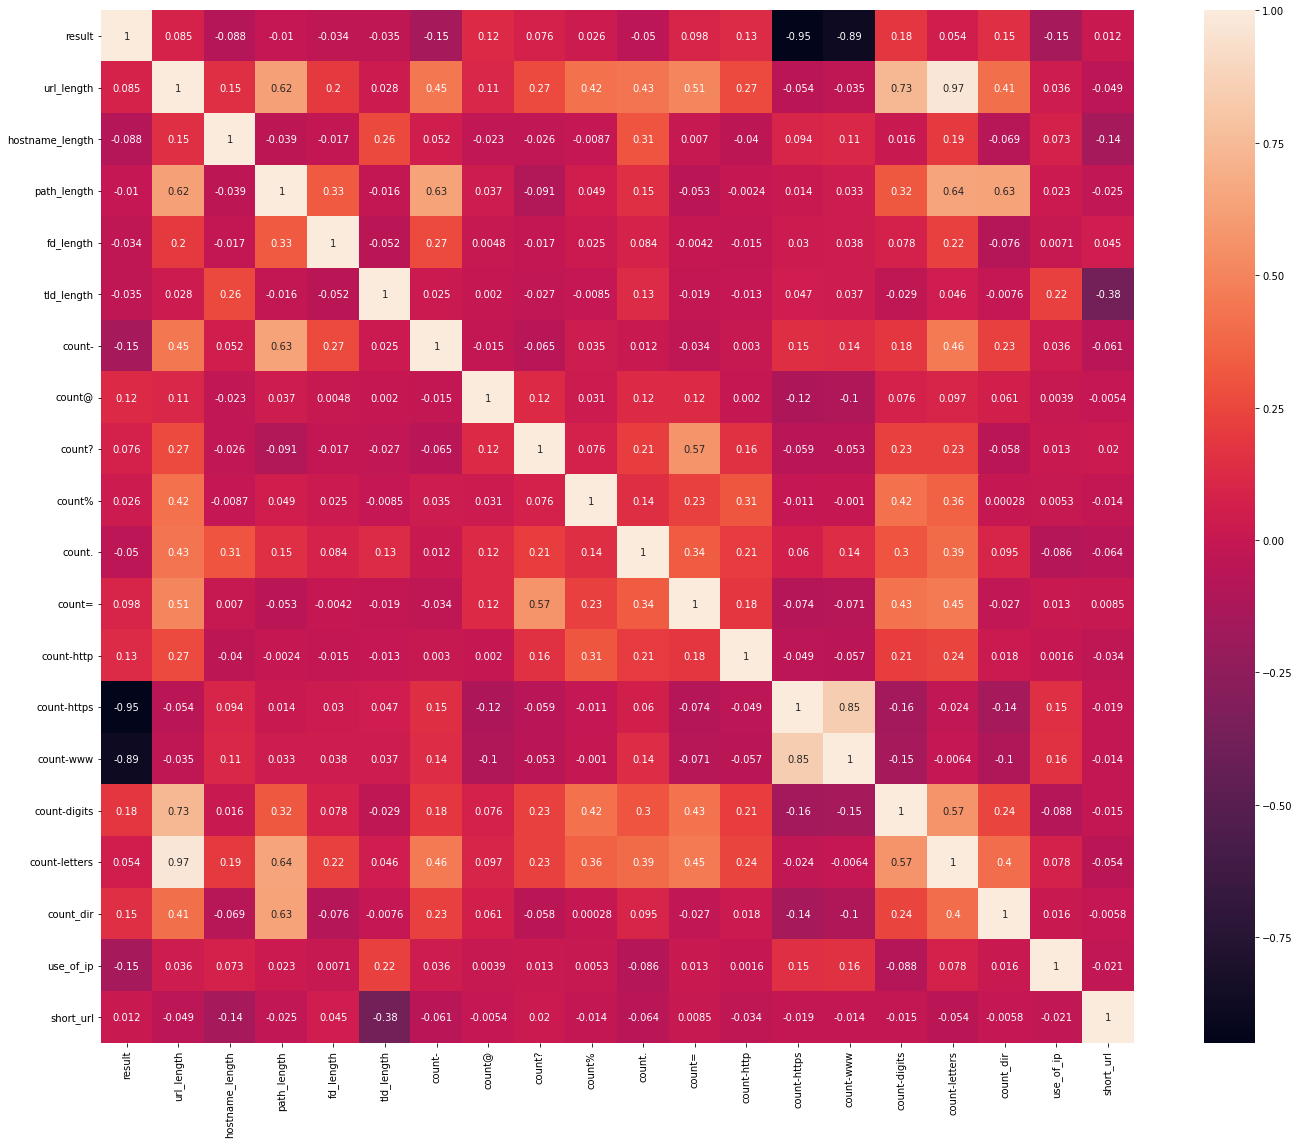

In [ ]:
corrmat = urldata.corr()
f, ax = plt.subplots(figsize=(25,19))
sns.heatmap(corrmat, square=True, annot = True, annot_kws={'size':10})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


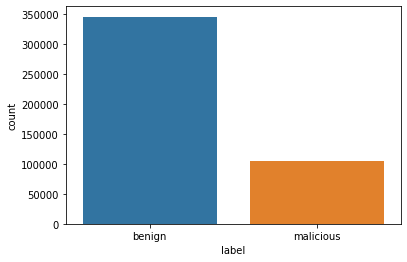

In [ ]:
sns.countplot(urldata['label'])

(0.0, 1000.0)

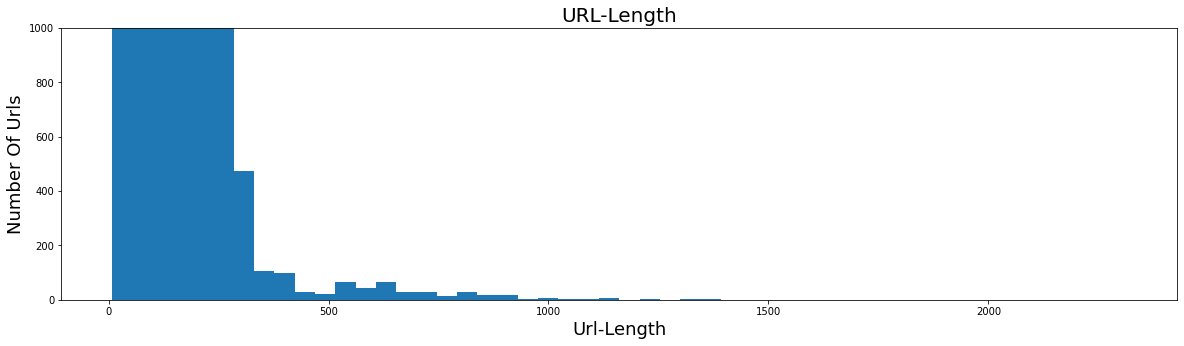

In [ ]:
plt.figure(figsize=(20,5))
plt.hist(urldata['url_length'],bins=50)
plt.title("URL-Length",fontsize=20)
plt.xlabel("Url-Length",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

(0.0, 1000.0)

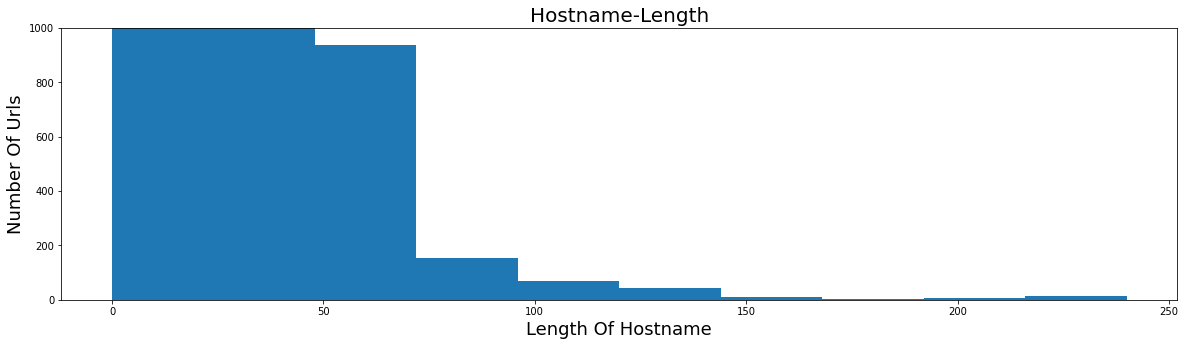

In [ ]:
plt.figure(figsize=(20,5))
plt.hist(urldata['hostname_length'])
plt.title("Hostname-Length",fontsize=20)
plt.xlabel("Length Of Hostname",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

Text(0, 0.5, 'Number Of URLs')

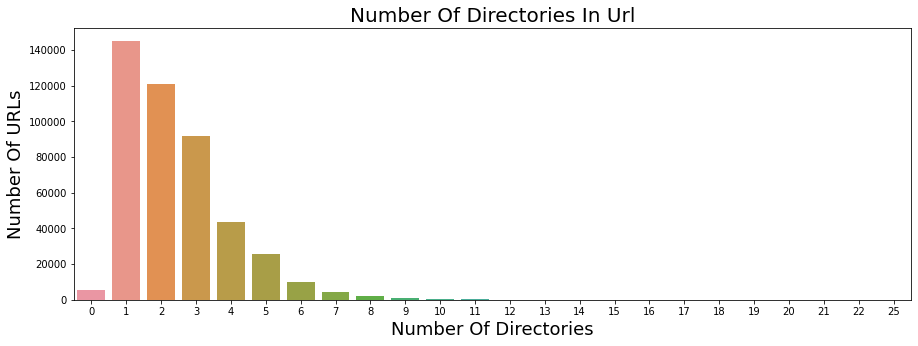

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Number Of Directories In Url",fontsize=20)
sns.countplot(x='count_dir',data=urldata)
plt.xlabel("Number Of Directories",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of URLs')

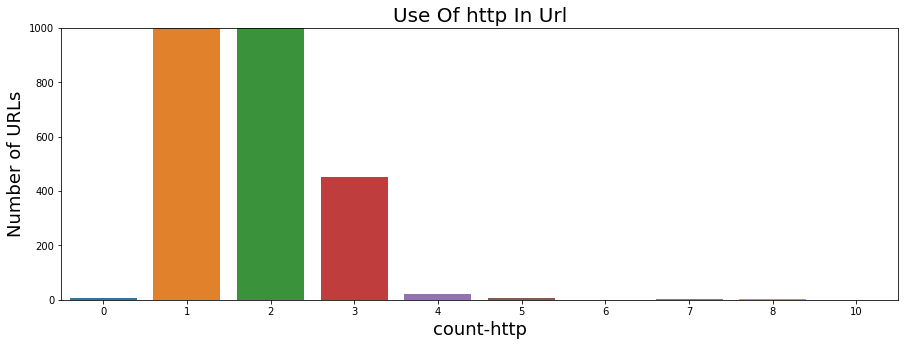

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Count http",fontsize=18)
plt.ylim((0,1000))
sns.countplot(urldata['count-http'])
plt.ylabel("Number of URLs",fontsize=18)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of URLs')

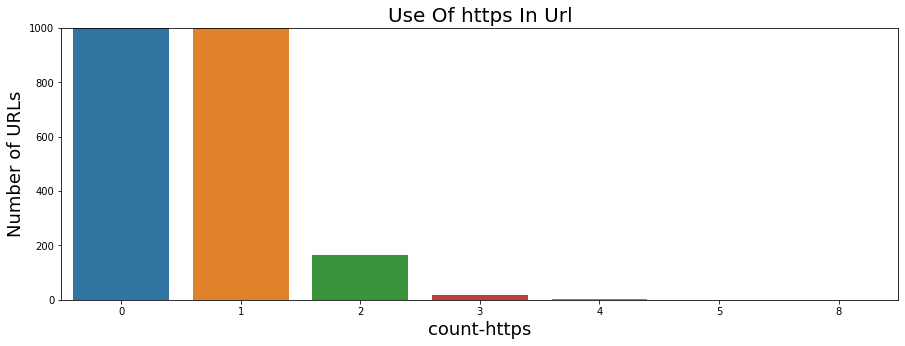

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Use Of https In Url",fontsize=20)
plt.xlabel("Count https",fontsize=18)
plt.ylim((0,1000))
sns.countplot(urldata['count-https'])
plt.ylabel("Number of URLs",fontsize=18)

In [ ]:
#Predictor Variables
X = urldata[['hostname_length',
       'path_length', 'fd_length', 'tld_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']]

#Target Variable
y = urldata['result']

In [ ]:
print(X.shape)
print(y.shape)

(450176, 17)
(450176,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lgs = LogisticRegression()
lgs.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
ypred_lr = lgs.predict(X_test)
print (ypred_lr)

[1 0 0 ... 1 0 0]


In [ ]:
lr_acc = accuracy_score(y_test, ypred_lr)
print("Accuracy: {}".format(lr_acc))
#Recall score
print("Recall Score: {}".format(recall_score(y_test, ypred_lr, average='weighted')))
#Precision Score
print('Precision Score: {}'.format(precision_score(y_test, ypred_lr, average='weighted')))
#F1 Score
print('F1 Score: {}'.format(f1_score(y_test, ypred_lr, average='weighted')))
# ROC AUC Score
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, ypred_lr, average='weighted')))

Accuracy: 0.9957730924969218
Recall Score: 0.9957730924969218
Precision Score: 0.9957701595199347
F1 Score: 0.9957710531127333
ROC AUC Score: 0.9935913372192509


**Gaussian** **Naive** **Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [ ]:
ypred_nb = nb.predict(X_test)
print (ypred_nb)

[1 0 0 ... 1 0 0]


In [ ]:
nb_acc = accuracy_score(y_test, ypred_nb)
print("Accuracy: {}".format(nb_acc))
#Recall score
print("Recall Score: {}".format(recall_score(y_test, ypred_nb, average='weighted')))
#Precision Score
print('Precision Score: {}'.format(precision_score(y_test, ypred_nb, average='weighted')))
#F1 Score
print('F1 Score: {}'.format(f1_score(y_test, ypred_nb, average='weighted')))
# ROC AUC Score
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, ypred_nb, average='weighted')))

Accuracy: 0.9914605044363488
Recall Score: 0.9914605044363488
Precision Score: 0.9916140804168637
F1 Score: 0.9914954424252217
ROC AUC Score: 0.9921938689724529


**SVM**

In [ ]:
from sklearn.svm import SVC
svc = SVC()

svc.fit(X_train, y_train)

SVC()

In [ ]:
ypred_svc = svc.predict(X_test)
print (ypred_svc)

[1 0 0 ... 1 0 0]


In [ ]:
svc_acc = accuracy_score(y_test, ypred_svc)
print("Accuracy: {}".format(svc_acc))
#Recall score
print("Recall Score: {}".format(recall_score(y_test, ypred_svc, average='weighted')))
#Precision Score
print('Precision Score: {}'.format(precision_score(y_test, ypred_svc, average='weighted')))
#F1 Score
print('F1 Score: {}'.format(f1_score(y_test, ypred_svc, average='weighted')))
# ROC AUC Score
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, ypred_svc, average='weighted')))

Accuracy: 0.9839079219608788
Recall Score: 0.9839079219608788
Precision Score: 0.9840997861206727
F1 Score: 0.9837330732573419
ROC AUC Score: 0.9670647754357057


**Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=10)
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=10)

In [ ]:
ypred_dt = dt.predict(X_test)
print (ypred_dt)

[1 0 0 ... 1 0 0]


In [ ]:
dt_acc = accuracy_score(y_test, ypred_dt)
print("Accuracy: {}".format(dt_acc))
#Recall score
print("Recall Score: {}".format(recall_score(y_test, ypred_dt, average='weighted')))
#Precision Score
print('Precision Score: {}'.format(precision_score(y_test, ypred_dt, average='weighted')))
#F1 Score
print('F1 Score: {}'.format(f1_score(y_test, ypred_dt, average='weighted')))
# ROC AUC Score
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, ypred_dt, average='weighted')))

Accuracy: 0.9955953846739696
Recall Score: 0.9955953846739696
Precision Score: 0.9955950157626765
F1 Score: 0.9955951956787061
ROC AUC Score: 0.9937806799012485


**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=323)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=323)

In [ ]:
ypred_rf = rf.predict(X_test)
print (ypred_rf)

[1 0 0 ... 1 0 0]


In [ ]:
rf_acc = accuracy_score(y_test, ypred_rf)
print("Accuracy: {}".format(rf_acc))
#Recall score
print("Recall Score: {}".format(recall_score(y_test, ypred_rf, average='weighted')))
#Precision Score
print('Precision Score: {}'.format(precision_score(y_test, ypred_rf, average='weighted')))
#F1 Score
print('F1 Score: {}'.format(f1_score(y_test, ypred_rf, average='weighted')))
# ROC AUC Score
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, ypred_rf, average='weighted')))

Accuracy: 0.9972487020982217
Recall Score: 0.9972487020982217
Precision Score: 0.9972472418038443
F1 Score: 0.9972468275658526
ROC AUC Score: 0.9954627092755882


**LDA**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

In [ ]:
ypred_lda = lda.predict(X_test)
print(ypred_lda)

[1 0 0 ... 1 0 0]


In [ ]:
lda_acc = accuracy_score(ypred_lda, y_test)
print("Accuracy: {}".format(lda_acc))
#Recall score
print("Recall Score: {}".format(recall_score(y_test, ypred_lda, average='weighted')))
#Precision Score
print('Precision Score: {}'.format(precision_score(y_test, ypred_lda, average='weighted')))
#F1 Score
print('F1 Score: {}'.format(f1_score(y_test, ypred_lda, average='weighted')))
# ROC AUC Score
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, ypred_lda, average='weighted')))

Accuracy: 0.9843997918279789
Recall Score: 0.9843997918279789
Precision Score: 0.9847100307081644
F1 Score: 0.9842071894560006
ROC AUC Score: 0.9664126822854288


**ANN**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model = Sequential()
model.add(Dense(16,activation='relu',input_dim=17))
model.add(Dense(1,activation='sigmoid'))
#optimizer=adam
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.1646 - accuracy: 0.9483
Epoch 2/10
4221/4221 [==============================] - 6s 2ms/step - loss: 0.0252 - accuracy: 0.9943
Epoch 3/10
4221/4221 [==============================] - 6s 2ms/step - loss: 0.0215 - accuracy: 0.9955
Epoch 4/10
4221/4221 [==============================] - 6s 2ms/step - loss: 0.0207 - accuracy: 0.9956
Epoch 5/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0201 - accuracy: 0.9957
Epoch 6/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0197 - accuracy: 0.9958
Epoch 7/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0192 - accuracy: 0.9960
Epoch 8/10
4221/4221 [==============================] - 6s 2ms/step - loss: 0.0193 - accuracy: 0.9960
Epoch 9/10
4221/4221 [==============================] - 6s 1ms/step - loss: 0.0192 - accuracy: 0.9959
Epoch 10/10
4221/4221 [==============================] - 6s 2ms/step - loss: 0.018

In [ ]:
Y_pred_nn_o1 = model.predict(X_test)

In [ ]:
rounded = [round(x[0]) for x in Y_pred_nn_o1]

Y_pred_nn_o1 = rounded

In [ ]:
nn_o1_acc = round(accuracy_score(Y_pred_nn_o1,y_test)*100,2)

print("The accuracy score achieved using Neural Network(Optimizer=Adam) is: "+str(nn_o1_acc)+" %")

The accuracy score achieved using Neural Network(Optimizer=Adam) is: 99.53 %


In [ ]:
#Recall score
print("Recall Score: {}".format(recall_score(y_test,Y_pred_nn_o1,average='weighted')))
#Precision Score
print('Precision Score: {}'.format(precision_score(y_test,Y_pred_nn_o1,average='weighted')))
#F1 Score
print('F1 Score: {}'.format(f1_score(y_test,Y_pred_nn_o1,average='weighted')))
# ROC AUC Score
print('ROC AUC Score: {}'.format(roc_auc_score(y_test,Y_pred_nn_o1,average='weighted')))

Recall Score: 0.99532564958556
Precision Score: 0.9953212416014391
F1 Score: 0.995320735850816
ROC AUC Score: 0.9923990528332716


In [ ]:
model = Sequential()
model.add(Dense(16,activation='relu',input_dim=17))
model.add(Dense(1,activation='sigmoid'))
#optimizer=Adamax
model.compile(loss='binary_crossentropy',optimizer='Adamax',metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,epochs=10)

Epoch 1/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.3149 - accuracy: 0.9095
Epoch 2/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0404 - accuracy: 0.9911
Epoch 3/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0299 - accuracy: 0.9938
Epoch 4/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0260 - accuracy: 0.9946
Epoch 5/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0239 - accuracy: 0.9952
Epoch 6/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0226 - accuracy: 0.9954
Epoch 7/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0217 - accuracy: 0.9954
Epoch 8/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0212 - accuracy: 0.9955
Epoch 9/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0207 - accuracy: 0.9956
Epoch 10/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.020

In [ ]:
Y_pred_nn_o2 = model.predict(X_test)

In [ ]:
rounded = [round(x[0]) for x in Y_pred_nn_o2]

Y_pred_nn_o2 = rounded

In [ ]:
nn_o2_acc = round(accuracy_score(Y_pred_nn_o2,y_test)*100,2)

print("The accuracy score achieved using Neural Network(optimizer=Adamax) is: "+str(nn_o2_acc)+" %")

The accuracy score achieved using Neural Network(optimizer=Adamax) is: 99.55 %


In [ ]:
#Recall score
print("Recall Score: {}".format(recall_score(y_test,Y_pred_nn_o2,average='weighted')))
#Precision Score
print('Precision Score: {}'.format(precision_score(y_test,Y_pred_nn_o2,average='weighted')))
#F1 Score
print('F1 Score: {}'.format(f1_score(y_test,Y_pred_nn_o2,average='weighted')))
# ROC AUC Score
print('ROC AUC Score: {}'.format(roc_auc_score(y_test,Y_pred_nn_o2,average='weighted')))

Recall Score: 0.9955097041164748
Precision Score: 0.995507349503937
F1 Score: 0.9955082787351395
ROC AUC Score: 0.9933864487700332


In [ ]:
model = Sequential()
model.add(Dense(16,activation='relu',input_dim=17))
model.add(Dense(1,activation='sigmoid'))
#optimizer=Nadam
model.compile(loss='binary_crossentropy',optimizer='Nadam',metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
4221/4221 [==============================] - 8s 2ms/step - loss: 0.2524 - accuracy: 0.9407
Epoch 2/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0286 - accuracy: 0.9941
Epoch 3/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0225 - accuracy: 0.9954
Epoch 4/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0209 - accuracy: 0.9956
Epoch 5/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0209 - accuracy: 0.9957
Epoch 6/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0203 - accuracy: 0.9957
Epoch 7/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0200 - accuracy: 0.9959
Epoch 8/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0199 - accuracy: 0.9959
Epoch 9/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.0193 - accuracy: 0.9960
Epoch 10/10
4221/4221 [==============================] - 7s 2ms/step - loss: 0.019

In [ ]:
Y_pred_nn_o3 = model.predict(X_test)

In [ ]:
rounded = [round(x[0]) for x in Y_pred_nn_o3]

Y_pred_nn_o3 = rounded

In [ ]:
nn_o3_acc = round(accuracy_score(Y_pred_nn_o3,y_test)*100,2)

print("The accuracy score achieved using Neural Network(optimizer=Nadam) is: "+str(nn_o3_acc)+" %")

The accuracy score achieved using Neural Network(optimizer=Nadam) is: 99.51 %


In [ ]:
#Recall score
print("Recall Score: {}".format(recall_score(y_test,Y_pred_nn_o3,average='weighted')))
#Precision Score
print('Precision Score: {}'.format(precision_score(y_test,Y_pred_nn_o3,average='weighted')))
#F1 Score
print('F1 Score: {}'.format(f1_score(y_test,Y_pred_nn_o3,average='weighted')))
# ROC AUC Score
print('ROC AUC Score: {}'.format(roc_auc_score(y_test,Y_pred_nn_o3,average='weighted')))

Recall Score: 0.9950813013290006
Precision Score: 0.9950929615759893
F1 Score: 0.9950672203236733
ROC AUC Score: 0.9902760543714743


**AdaBoostClassifier**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(X_train,y_train)

AdaBoostClassifier()

In [ ]:
ypred_ada = abc.predict(X_test)

In [ ]:
ada_acc = accuracy_score(ypred_ada, y_test)
print("Accuracy: {}".format(ada_acc))
#Recall score
from sklearn.metrics import recall_score
print("Recall Score: {}".format(recall_score(ypred_ada, y_test, average='weighted')))
#Precision Score
from sklearn.metrics import precision_score
print('Precision Score: {}'.format(precision_score(ypred_ada, y_test, average='weighted')))
#F1 Score
from sklearn.metrics import f1_score
print('F1 Score: {}'.format(f1_score(ypred_ada, y_test, average='weighted')))
# ROC AUC Score
from sklearn.metrics import roc_auc_score
print('ROC AUC Score: {}'.format(roc_auc_score(ypred_ada, y_test, average='weighted')))

Accuracy: 0.9963982432312359
Recall Score: 0.9963982432312359
Precision Score: 0.9963991125352794
F1 Score: 0.9963986468927364
ROC AUC Score: 0.9950592624543938


In [ ]:
scores = [lr_acc*100, nb_acc*100, svc_acc*100, dt_acc*100, rf_acc*100,
          lda_acc*100, nn_o1_acc, nn_o2_acc, nn_o3_acc, ada_acc*100]
algorithms = ["Logistic Regression", "Naive Bayes", "SVM", "Decision Tree", "Random Forest",
              "LDA", "ANN(Adam)", "ANN(Adamax)", "ANN(Nadam)", "AdaBoost"]

for i in range(len(algorithms)):
    print("The accuracy score achieved using "+algorithms[i]+" is: "+str(scores[i])+" %")

The accuracy score achieved using Logistic Regression is: 99.57730924969218 %
The accuracy score achieved using Naive Bayes is: 99.14605044363488 %
The accuracy score achieved using SVM is: 98.39079219608789 %
The accuracy score achieved using Decision Tree is: 99.55953846739696 %
The accuracy score achieved using Random Forest is: 99.72487020982217 %
The accuracy score achieved using LDA is: 98.43997918279788 %
The accuracy score achieved using ANN(Adam) is: 99.53 %
The accuracy score achieved using ANN(Adamax) is: 99.55 %
The accuracy score achieved using ANN(Nadam) is: 99.51 %
The accuracy score achieved using AdaBoost is: 99.63982432312359 %


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


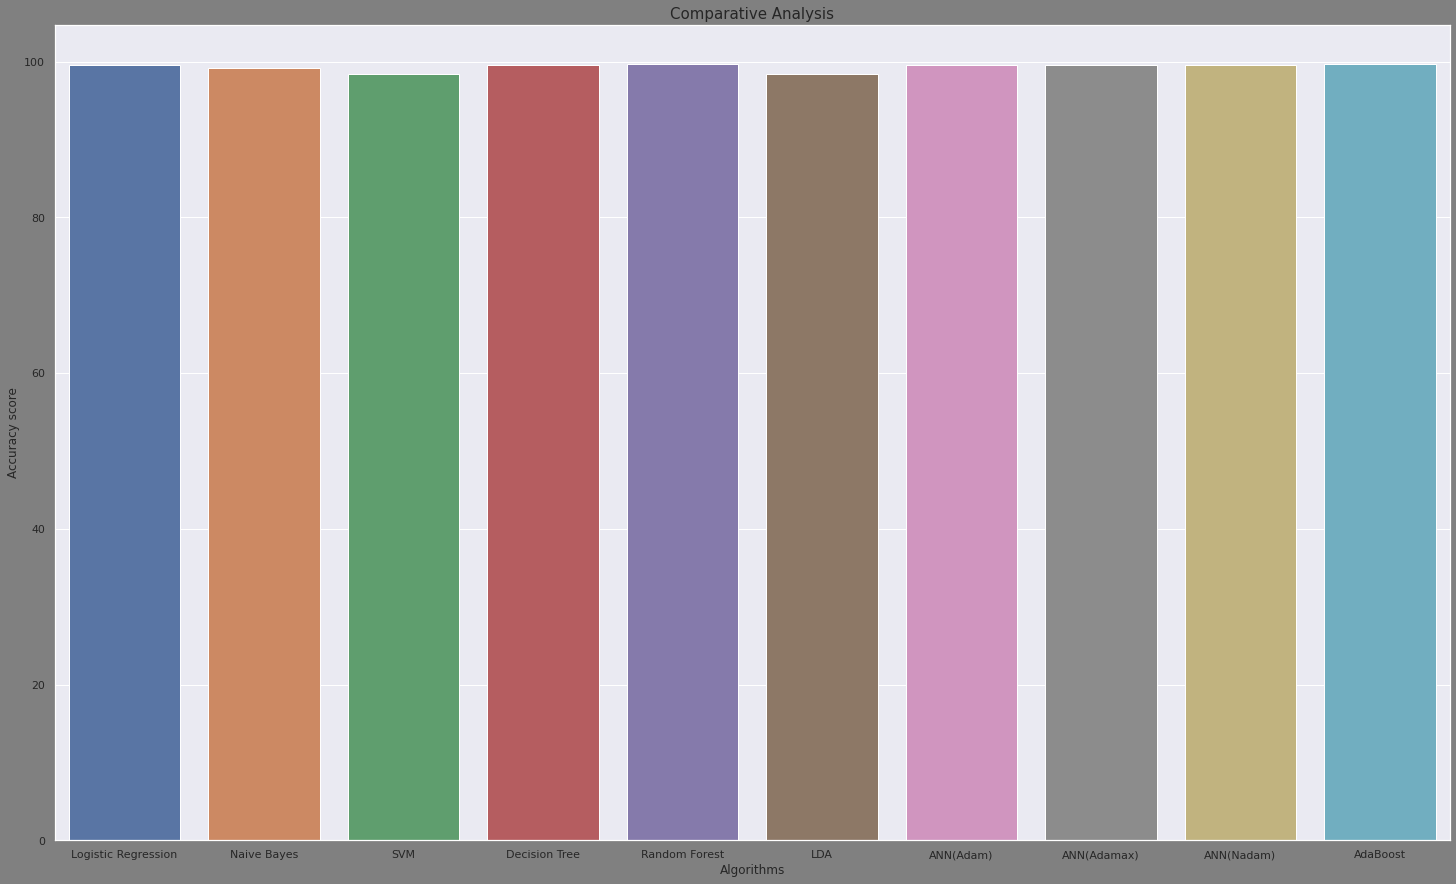

In [ ]:
#Plot of Accuracy Score for different models
fig = plt.figure()
fig.patch.set_facecolor('grey')

sns.set(rc={'figure.figsize':(25,15)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")


plt.title("Comparative Analysis", fontsize=15)

sns.barplot(algorithms,scores)
plt.show()

<Figure size 2160x5040 with 0 Axes>

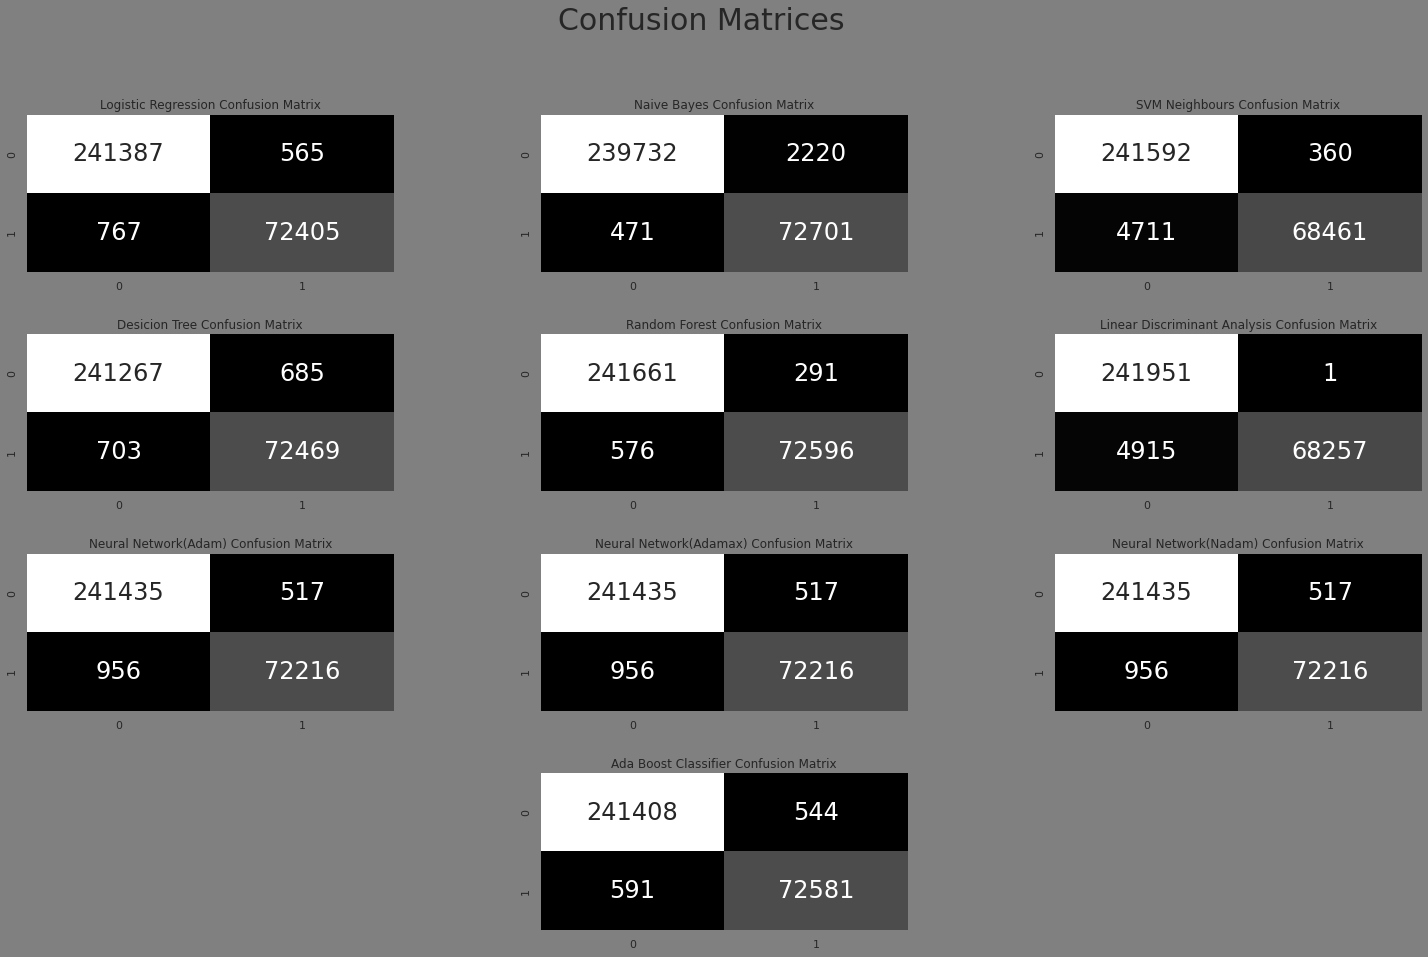

In [ ]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, ypred_lr)
cm_nb = confusion_matrix(y_test, ypred_nb)
cm_svm = confusion_matrix(y_test, ypred_svc)
cm_dt = confusion_matrix(y_test, ypred_dt)
cm_rf = confusion_matrix(y_test, ypred_rf)
cm_lda = confusion_matrix(y_test, ypred_lda)
cm_nn_o1 = confusion_matrix(y_test, Y_pred_nn_o1)
cm_nn_o2 = confusion_matrix(y_test, Y_pred_nn_o2)
cm_nn_o3 = confusion_matrix(y_test, Y_pred_nn_o3)
cm_ada = confusion_matrix(y_test, ypred_ada)


plt.figure(figsize=(30,70))
#plt.rcParams['axes.facecolor'] = 'black'#plt.figure.patch.set_facecolor('black')
fig = plt.figure()
fig.patch.set_facecolor('grey')

plt.suptitle("Confusion Matrices",fontsize=30)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(4,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="gist_gray",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,2)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="gist_gray",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,3)
plt.title("SVM Neighbours Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="gist_gray",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,4)
plt.title("Desicion Tree Confusion Matrix")
sns.heatmap(cm_dt,annot=True,cmap="gist_gray",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,5)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(cm_rf,annot=True,cmap="gist_gray",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,6)
plt.title("Linear Discriminant Analysis Confusion Matrix")
sns.heatmap(cm_lda,annot=True,cmap="gist_gray",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,7)
plt.title("Neural Network(Adam) Confusion Matrix")
sns.heatmap(cm_nn_o1,annot=True,cmap="gist_gray",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,8)
plt.title("Neural Network(Adamax) Confusion Matrix")
sns.heatmap(cm_nn_o1,annot=True,cmap="gist_gray",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,9)
plt.title("Neural Network(Nadam) Confusion Matrix")
sns.heatmap(cm_nn_o1,annot=True,cmap="gist_gray",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,11)
plt.title("Ada Boost Classifier Confusion Matrix")
sns.heatmap(cm_ada,annot=True,cmap="gist_gray",fmt="d",cbar=False, annot_kws={"size": 24})
plt.show()
